In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from utils import stem_plot, upc_decode, decode_image

try:
    dir_ = Path(__file__).parent
except:
    dir_ = Path.cwd()

# %config InlineBackend.figure_formats = ['svg']
from IPython.display import HTML

# ECE 6530 DSP Project
### Edge Detection and Bar Code Decoding
Group Members: Grant Brown, Thomas Warren


Setup
---------

To generate this report and the associated plots:

1. Install Python 3.11.
2. Open a terminal window and navigate to the directory containing the project files. 
2. Create an virtual environment for the report/project. See [here](https://docs.python.org/3/library/venv.html) for more information.  
`> python -m venv .venv`
4. In the newly created environment, install the required packages from the requirements.txt file included with the project files.  
`(.venv) > pip install -r requirements.txt`
5. Open the report with Jupyter Notebooks.  
`(.venv) > jupyter notebook lab10.ipynb`
6. The notebook should open in the default browser. 

7. To generate the .html version of the report,  
`(.venv) > jupyter nbconvert --to html lab10.ipynb`

# 3.1
----
Implement the first difference FIR filter,
$$
y[n] = x[n] - x[n-1]
$$

On the following signal,
```
xn = 255*(rem(1:159,30)>19)
```

The signal is implemented in Python with,
```python
xn = 255 * ((x % 30) > 19)
```

The impulse response $h[n]$ for this FIR filter is,
$$
h[n] = [1, -1]
$$

## (a)
Plot both the input and output waveforms $x[n]$ and $y[n]$. 

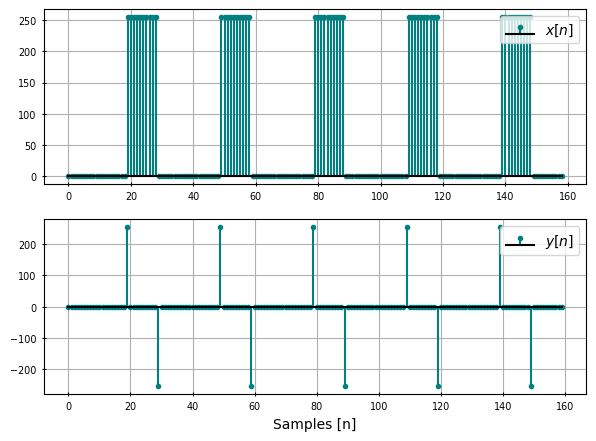

In [2]:
n = np.arange(1, 160)
xn = 255 * ((n % 30) > 19)

hn = np.array([1, -1])
# apply the FIR filter to the input signal using convolution
yn = np.convolve(xn, hn)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))
stem_plot(ax1, np.arange(len(xn)), xn, markersize=3)
stem_plot(ax2, np.arange(len(yn)), yn, markersize=3)
ax1.legend(["$x[n]$"], loc='upper right')
ax2.legend(["$y[n]$"], loc='upper right')
ax2.set_xlabel('Samples [n]');

## (b)
The output $y[n]$ is simply the difference of the current sample $n$ with the previous sample value at $n-1$. When the input $x[n]$ is constant between the current and last sample, the output is zero, but is non-zero when an edge occurs. The value of $y[n]$ at the edges is the difference in the two sample values, so it has a value of 255 when the input transitions from 0 to 255 (positive edge), and -255 when the input transitions from 255 back to 0 (negative edge).

## (c)

The length of $y[n]$ is related to the length of the input at the filter impulse response using the convolution property,

$$
\mathrm{len}(y[n]) = \mathrm{len}(x[n])+ \mathrm{len}({h[n]}) -1 
$$

In [3]:
print("XN:{} HN: {}, YN: {}".format(len(xn), len(hn), len(yn)))

XN:159 HN: 2, YN: 160


## (d)

Determine an appropriate value of the threshold $\tau$ to get the edges of the input. 

$$ d[n] = 
\begin{cases}
\mathrm{Edge \ True} & \mathrm{if \ } |y[n]|  > \tau \\
\mathrm{Edge \ False} & \mathrm{if \ } |y[n]| < \tau
\end{cases}
$$

For this signal, an appropriate threshold is half of the maximum value of $x[n]$ or 255.
$$ \tau = \mathrm{max}(x[n]) /2 $$

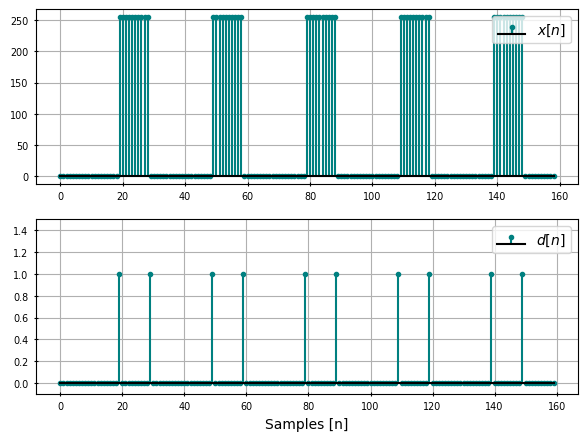

In [4]:
# normalized edge detector
tau = 255 / 2
edges_n = np.where(np.abs(yn) > tau, 1, 0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))
stem_plot(ax1, np.arange(len(xn)), xn, markersize=3)
stem_plot(ax2, np.arange(len(edges_n)), edges_n, markersize=3)
ax2.set_ylim([-0.1, 1.5])
ax1.legend(["$x[n]$"], loc='upper right')
ax2.legend(["$d[n]$"], loc='upper right')
ax2.set_xlabel('Samples [n]');

## (e)

Produce a shorter signal that contains the edge locations. Determine the length of this signal and plot it.

The length of this signal is 10 samples since there are 10 edges in the input signal.

Length of edge signal: 10


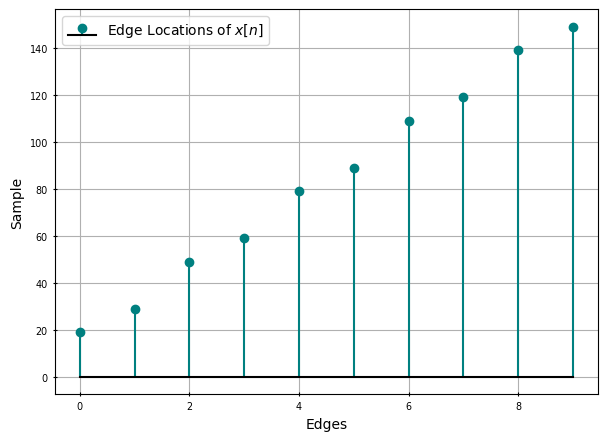

In [5]:
edges_samples = np.nonzero(edges_n)[0]

fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
stem_plot(ax1, np.arange(len(edges_samples)), edges_samples)
ax1.grid(True)
ax1.set_ylabel("Sample")
ax1.set_xlabel("Edges")
ax1.legend(["Edge Locations of $x[n]$"], loc='upper left');
print(f"Length of edge signal: {len(edges_samples)}")

# 3.2
----
Develop the signal processing needed to decode a typical bar code from a scanned image.

## (a)
Read the image HP110v3.png and extract one row in the middle to define a 1-D signal x[n] for processing.

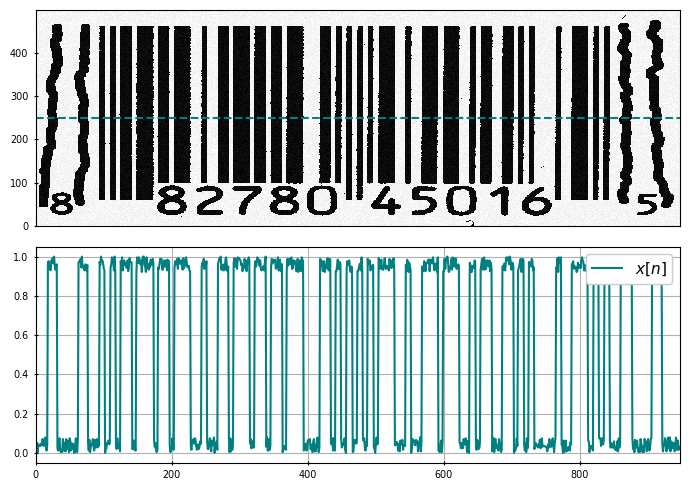

In [6]:
imagepath = dir_ / "data/HP110v3.png"
im = 1 - plt.imread(imagepath)

# x and y vectors along image [pixels]
m, n = np.arange(len(im)), np.arange(len(im[0]))

# extract one row to read
read_row = int(len(m) / 2) - 1
xn = im[read_row]

fig, (im1, ax1) = plt.subplots(2, 1, figsize=(7, 5))
# plot the image, n is the columns which we want on the x-axis
n_mesh, m_mesh = np.meshgrid(n, np.flip(m))
im1.pcolormesh(n_mesh, m_mesh, im, cmap="binary")
im1.grid(False)
# plot the location of the single row used for processing
im1.axhline(y=read_row, linestyle="dashed")
ax1.plot(np.arange(len(xn)), xn)
ax1.legend(["$x[n]$"], fontsize=11, loc="upper right", framealpha=1)

ax2.set_xlabel("Pixel [n]")
im1.set_xticks([])
for ax in (im1, ax1):
    ax.set_xlim([n[0], n[-1]])
    

plt.tight_layout()

# (b)
Filter the signal $x[n]$ with a first difference FIR filter. 
$$
y[n] = x[n] - x[n-1]
$$

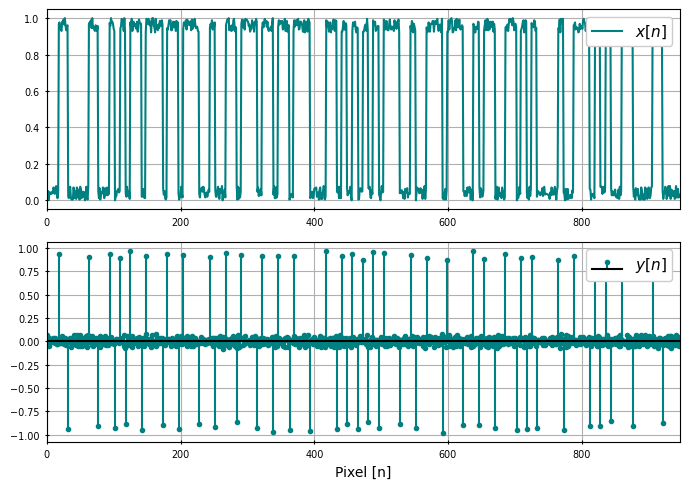

In [7]:
hn = np.array([1, -1])
yn = np.convolve(xn, hn)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))
ax1.plot(np.arange(len(xn)), xn)
stem_plot(ax2, np.arange(len(yn)), yn, markersize=3)

ax1.legend(["$x[n]$"], fontsize=11, loc="upper right", framealpha=1)
ax2.legend(["$y[n]$"], fontsize=11, loc="upper right", framealpha=1)

ax2.set_xlabel("Pixel [n]")
for ax in (im1, ax1, ax2):
    ax.set_xlim([n[0], n[-1]])

plt.tight_layout()

# (c)
Create a sparse detected signal $d[n]$ by comparing the magnitude $|y[n]|$ to a threshold.

Use $\tau=0.5$ as the edge threshold.

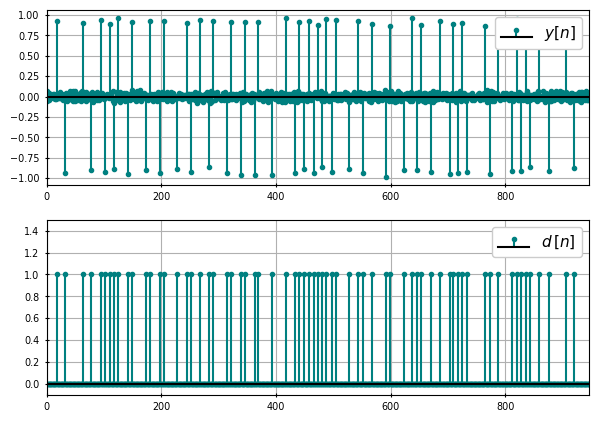

In [8]:
dn = np.where(np.abs(yn) > 0.5, 1, 0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))

stem_plot(ax1, np.arange(len(yn)), yn, markersize=3)
stem_plot(ax2, np.arange(len(dn)), dn, markersize=3)
ax2.set_ylim([-0.1, 1.5])

ax1.legend(["$y[n]$"], fontsize=11, loc="upper right", framealpha=1)
ax2.legend(["$d \, [n]$"], fontsize=11, loc="upper right", framealpha=1);

for ax in (im1, ax1, ax2):
    ax.set_xlim([n[0], n[-1]])

Then convert the sparse signal $d[n]$ into a location signal $\ell[n]$ by using the find function to extract locations.

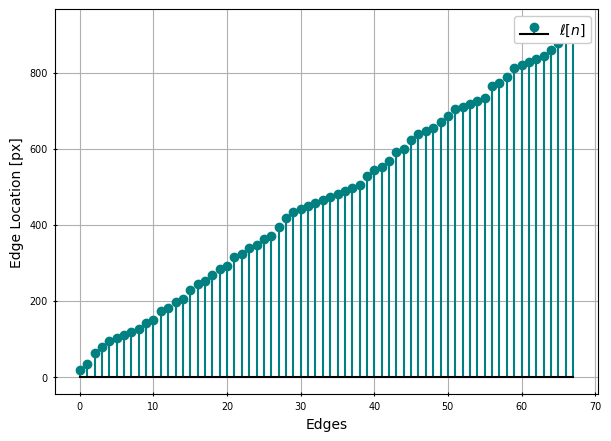

In [9]:
# pixel locations where edges occur
edge_loc = np.nonzero(dn)[0]

fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))
stem_plot(ax1, np.arange(len(edge_loc)), edge_loc)
ax1.set_ylabel('Edge Location [px]')
ax1.set_xlabel('Edges')
ax1.legend(["$\ell[n]$"], loc="upper right", framealpha=1)

## (d)
Apply a first difference filter to $\ell[n]$, call this signal $\Delta[n]$, which should be the width of each bar.

All of the bar widths of $\Delta[n]$ are grouped around four distinct values (8, 16, 24, 32px), which indicates there are 4 unique bar widths. 

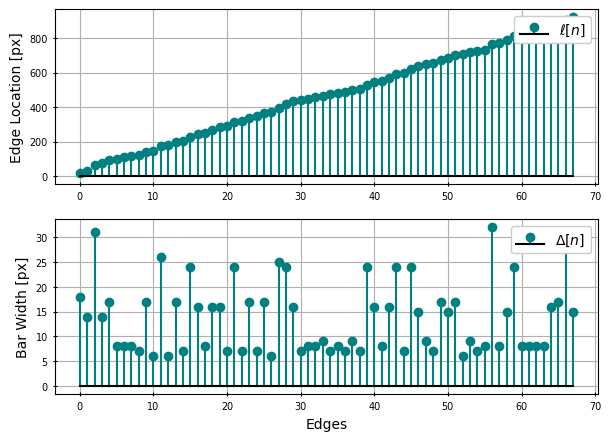

In [10]:
# difference filter on the location signal
delta_n = np.convolve(edge_loc, hn, mode="same")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))
stem_plot(ax1, np.arange(len(edge_loc)), edge_loc)
stem_plot(ax2, np.arange(len(delta_n)), delta_n)

ax1.set_ylabel('Edge Location [px]')
ax2.set_ylabel('Bar Width [px]')
ax2.set_xlabel('Edges')

ax1.legend(["$\ell[n]$"], loc="upper right", framealpha=1)
ax2.legend(["$\Delta[n]$"], loc="upper right", framealpha=1);

## (e)
Prove that the total width of a valid 12-digit bar code is equal to 95 $\theta_1$, where $\theta_1$ is the minimum bar width in pixels. Write a logical
argument to justify this total width.

## (f)
Derive a simple method to estimate $\theta_1$ from the signal $\Delta[n]$.

For a valid barcode, the bar widths are multiples of the thinnest bar. This means that we can draw a line halfway between the bar widths with the smallest widths in $\Delta[n]$, and the next largest bars. Any bar below this line will be considered $\theta_1$, and any above are considered $2\theta_1$. To estimate $\theta_1$ for a noisy image, we average all the bar widths below this imaginary line, which we draw at 1.5x the minimum bar width found in the image.

This method gives $\theta_1 = 7.5$ for this image.

In [11]:
# determine minimum bar width in pixels
# take all widths smaller than 1.5x the minimum and take the average
min_width_group = delta_n[delta_n <= (np.min(delta_n) * 1.5)]
delta_1 = np.average(min_width_group)

print(f"delta_1 = {delta_1}")

delta_1 = 7.529411764705882


## (g)
Using the estimate for $\delta_1$, convert $\Delta[n]$ into relative sizes by dividing by $\theta_1$ and rounding. 

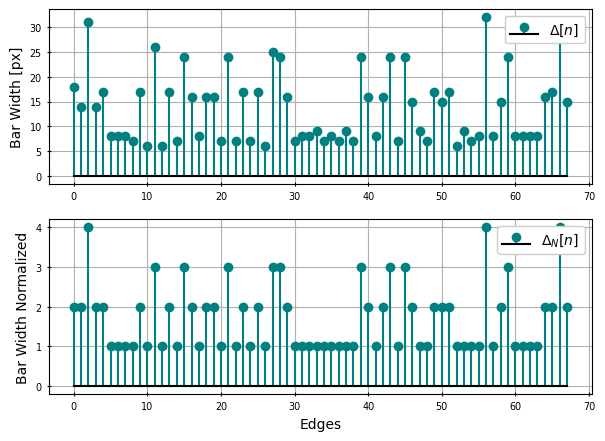

In [12]:
# normalize the bar widths by delta_1, and clip between 1 and 4.
delta_norm_n = np.clip(np.round(delta_n / delta_1), 1, 4)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))
stem_plot(ax1, np.arange(len(delta_n)), delta_n)
stem_plot(ax2, np.arange(len(delta_n)), delta_norm_n)

ax1.set_ylabel('Bar Width [px]')
ax2.set_ylabel('Bar Width Normalized')
ax2.set_xlabel('Edges')
ax2.set_yticks([0, 1, 2, 3, 4]);

ax1.legend(["$\Delta[n]$"], loc="upper right", framealpha=1)
ax2.legend(["$\Delta_N[n]$"], loc="upper right", framealpha=1)

## (h)
Decode the normalized $\Delta[n]$ signal into digits.

In [13]:
# find the first sequence of 3 ones, this marks the beginning and end of a valid code
delimiter_match = np.convolve(delta_norm_n, [1, 1, 1])
delimiter_loc = np.argwhere(delimiter_match == 3).flatten()
start_loc, stop_loc = delimiter_loc[0] - 2, delimiter_loc[-1]

# clip start location to 0
start_loc = 0 if start_loc < 0 else start_loc
# clip the sequence at the delimters
bar_w = delta_norm_n[start_loc : stop_loc + 1]

# a valid bar code should have 59 widths excluding the delimiters
assert len(bar_w) == 59

print(upc_decode(bar_w))

[8, 8, 2, 7, 8, 0, 4, 5, 0, 1, 6, 5]


# (i)

Check the result using the included code in the image.

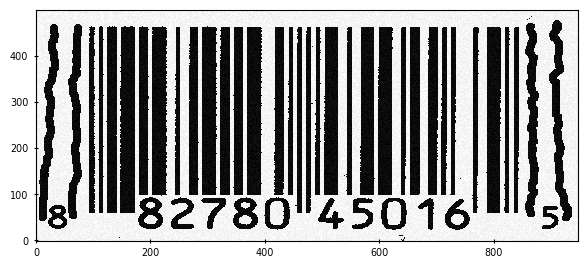

In [14]:
fig, (im1) = plt.subplots(1, 1, figsize=(7, 3))
# plot the image, n is the columns which we want on the x-axis
n_mesh, m_mesh = np.meshgrid(n, np.flip(m))
im1.pcolormesh(n_mesh, m_mesh, im, cmap="binary")
im1.grid(False)

# (j)

Process the image `Offv3.png`.

C:\Users\rlyon\DSP_Project\utils.py:137: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


[0, 4, 6, 5, 0, 0, 7, 0, 3, 1, 9, 5]

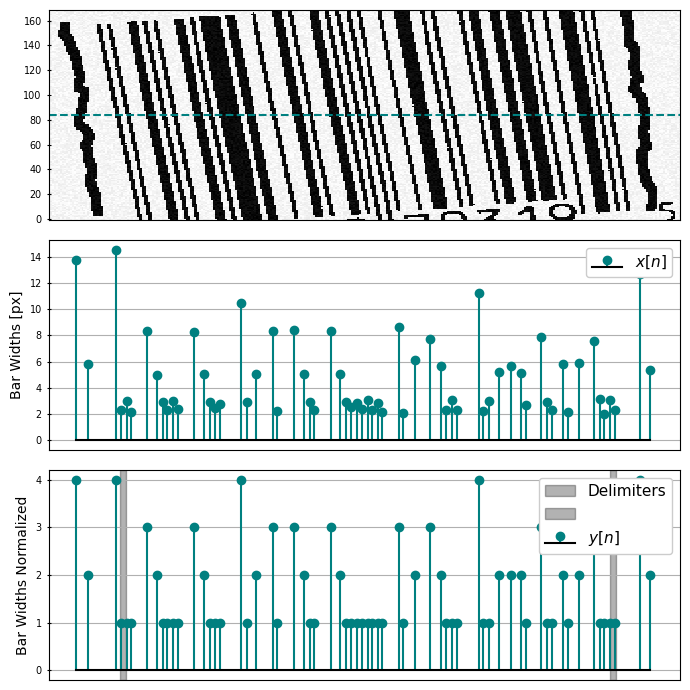

In [15]:
imagepath = dir_ / "data/OFFv3.png"
decode_image(imagepath)

In [ ]:
from IPython.display import display, HTML, Javascript
from ipylab import JupyterFrontEnd
import subprocess
app = JupyterFrontEnd()

display(
    HTML(
        "<style>"
        ".jp-Cell { overflow-x: visible; overflow: visible; "
        "width: 95%; max-width: 800px; "
        "margin-left: auto; margin-right: auto; }"
        "img {"
        "width: 90%;"
        "height: 100%;}"
        ".jp-Cell-inputWrapper { width: 95%; overflow-x: visible; overflow: visible;}"
        "</style>"
    )
)

app.commands.execute("docmanager:save")
subprocess.run("jupyter nbconvert --to html lab10.ipynb", shell=True)
app.commands.execute("docmanager:save");